# Link Prediction using Graph Neural Networks

In [2]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.5 MB/s eta 0:00:00


Dự đoán xem tồn tại hai cạnh giữa hai node hay không.

## Import thư viện

In [3]:
import itertools
import os

os.environ["DGLBACKEND"] = "pytorch"

import dgl
import dgl.data
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

## Overview of Link Prediction with GNN


Nhiều ứng dụng như đề xuất xã hội, đề xuất mục, hoàn thành biểu đồ tri thức, v.v., có thể được xây dựng dưới dạng dự đoán liên kết, dự đoán xem có tồn tại cạnh giữa hai nút cụ thể hay không. Hướng dẫn này cho thấy một ví dụ về dự đoán liệu mối quan hệ trích dẫn, trích dẫn hoặc được trích dẫn, giữa hai bài báo có tồn tại trong mạng trích dẫn hay không.

Hướng dẫn này xây dựng bài toán dự đoán liên kết dưới dạng bài toán phân loại nhị phân như sau:

Coi các cạnh trong biểu đồ là các ví dụ tích cực.

Lấy mẫu một số cạnh không tồn tại (tức là các cặp nút không có cạnh nào ở giữa chúng) làm ví dụ phủ định.

Chia các ví dụ tích cực và các ví dụ tiêu cực thành một tập huấn luyện và một tập kiểm tra.

Đánh giá mô hình với bất kỳ số liệu phân loại nhị phân nào, chẳng hạn như Diện tích dưới đường cong (AUC).

Trong một số lĩnh vực, chẳng hạn như hệ thống đề xuất quy mô lớn hoặc truy xuất thông tin, bạn có thể ưu tiên các số liệu nhấn mạnh hiệu suất tốt của các dự đoán top-K. Trong những trường hợp này, bạn có thể muốn xem xét các số liệu khác, chẳng hạn như độ chính xác trung bình trung bình và sử dụng các phương pháp lấy mẫu phủ định khác, nằm ngoài phạm vi của hướng dẫn này

## Loading graph and features¶

Following the introduction, this tutorial first loads the Cora dataset.

In [4]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


## Prepare training and testing sets

In [8]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.num_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.num_edges())
test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)

Khi huấn luyện, bạn sẽ cần loại bỏ các cạnh trong tập kiểm tra khỏi đồ thị ban đầu. Bạn có thể làm điều này thông qua
```
dgl.remove_edges
```



dgl.remove_edges hoạt động bằng cách tạo một biểu đồ con từ biểu đồ gốc, dẫn đến một bản sao và do đó có thể chậm đối với các biểu đồ lớn. Nếu vậy, bạn có thể lưu đồ thị huấn luyện và kiểm tra vào đĩa, giống như cách bạn làm để tiền xử lý.


In [9]:
train_g = dgl.remove_edges(g, eids[:test_size])

## Define a GraphSAGE model

In [10]:
from dgl.nn import SAGEConv


# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

Sau đó, mô hình dự đoán xác suất tồn tại của một cạnh bằng cách tính toán điểm số giữa các biểu diễn của cả hai nút sự cố có chức năng (ví dụ: MLP hoặc tích vô hướng), mà bạn sẽ thấy trong phần tiếp theo.

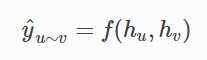

## Positive graph, negative graph, and ```apply_edges```

Trong các hướng dẫn trước, bạn đã học cách tính toán biểu diễn nút bằng GNN. Tuy nhiên, dự đoán liên kết yêu cầu bạn tính toán biểu diễn của các cặp nút.

DGL khuyên bạn nên coi các cặp nút là một đồ thị khác, vì bạn có thể mô tả một cặp nút bằng một cạnh. Trong dự đoán liên kết, bạn sẽ có một đồ thị dương bao gồm tất cả các ví dụ dương dưới dạng các cạnh và một biểu đồ âm bao gồm tất cả các mẫu âm. Biểu đồ dương và biểu đồ âm sẽ chứa cùng một tập hợp các nút như biểu đồ ban đầu. Điều này giúp dễ dàng chuyển các tính năng của nút giữa nhiều biểu đồ để tính toán. Như bạn sẽ thấy sau này, bạn có thể cung cấp trực tiếp các biểu diễn nút được tính toán trên toàn bộ đồ thị thành đồ thị dương và âm để tính toán điểm số theo cặp

Đoạn mã sau xây dựng đồ thị dương và đồ thị âm cho tập huấn luyện và tập kiểm tra tương ứng.

In [12]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.num_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.num_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.num_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.num_nodes())

Lợi ích của việc xử lý các cặp nút dưới dạng biểu đồ là bạn có thể sử dụng phương pháp DGLGraph.apply_edges, phương pháp này tính toán các tính năng cạnh mới một cách thuận tiện dựa trên các tính năng của nút sự cố và các tính năng cạnh ban đầu (nếu có).

DGL cung cấp một tập hợp các hàm dựng sẵn được tối ưu hóa để tính toán các tính năng biên mới dựa trên các tính năng nút/cạnh ban đầu. Ví dụ: dgl.function.u_dot_v tính toán tích vô hướng của các biểu diễn của nút sự cố cho mỗi cạnh.

In [11]:
import dgl.function as fn


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

Bạn cũng có thể viết chức năng của riêng mình nếu nó phức tạp. Chẳng hạn, mô-đun sau đây tạo ra điểm số vô hướng trên mỗi cạnh bằng cách kết hợp các đặc điểm của nút sự cố và chuyển nó tới MLP.

In [13]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src["h"], edges.dst["h"]], 1)
        return {"score": self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.apply_edges(self.apply_edges)
            return g.edata["score"]

## Training loop

Sau khi bạn xác định tính toán biểu diễn nút và tính toán điểm cạnh, bạn có thể tiếp tục và xác định mô hình tổng thể, hàm mất mát và chỉ số đánh giá.

Hàm mất mát chỉ đơn giản là mất mát entropy chéo nhị phân.

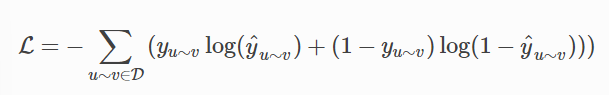

Số liệu đánh giá trong hướng dẫn này là AUC.

In [14]:
model = GraphSAGE(train_g.ndata["feat"].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
# pred = MLPPredictor(16)
pred = DotPredictor()


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

Vòng lặp đào tạo diễn ra như sau:

Hướng dẫn này không bao gồm đánh giá trên một bộ xác thực. Trong thực tế, bạn nên lưu và đánh giá mô hình tốt nhất dựa trên hiệu suất trên bộ xác thực.

In [15]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred.parameters()), lr=0.01
)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata["feat"])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score

with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print("AUC", compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.7063246369361877
In epoch 5, loss: 0.6889557242393494
In epoch 10, loss: 0.6701717972755432
In epoch 15, loss: 0.6371328830718994
In epoch 20, loss: 0.5830672979354858
In epoch 25, loss: 0.5299322605133057
In epoch 30, loss: 0.5155760645866394
In epoch 35, loss: 0.48525840044021606
In epoch 40, loss: 0.461059033870697
In epoch 45, loss: 0.43553802371025085
In epoch 50, loss: 0.41314345598220825
In epoch 55, loss: 0.39137542247772217
In epoch 60, loss: 0.3693632185459137
In epoch 65, loss: 0.3468959331512451
In epoch 70, loss: 0.3257376551628113
In epoch 75, loss: 0.3052924573421478
In epoch 80, loss: 0.28535664081573486
In epoch 85, loss: 0.2657342255115509
In epoch 90, loss: 0.2467852085828781
In epoch 95, loss: 0.2279975414276123
AUC 0.8615017632128659


# Make Your Own Dataset

Hướng dẫn này giả định rằng bạn đã biết kiến ​​thức cơ bản về đào tạo GNN để phân loại nút và cách tạo, tải và lưu trữ biểu đồ DGL.

Đến cuối hướng dẫn này, bạn sẽ có thể

Tạo tập dữ liệu biểu đồ của riêng bạn để phân loại nút, dự đoán liên kết hoặc phân loại biểu đồ.

(Thời gian ước tính: 15 phút)

## ```DGLDataset``` Object Overview¶

Tập dữ liệu biểu đồ tùy chỉnh của bạn phải kế thừa lớp ```dgl.data.DGLDataset``` và triển khai các phương thức sau:

```__getitem__(self, i)```: retrieve the ```i```-th example of the dataset. An example often contains a single DGL graph, and occasionally its label.

```__len__(self)```: the number of examples in the dataset.

```process(self)```: load and process raw data from disk

## Creating a Dataset for Node Classification or Link Prediction from CSV

Bộ dữ liệu phân loại nút thường bao gồm một biểu đồ duy nhất, cũng như các tính năng nút và cạnh của nó.

Hướng dẫn này sử dụng một tập dữ liệu nhỏ dựa trên mạng Câu lạc bộ Karate của Zachary. Nó chứa

Tệp ```members.csv``` chứa thuộc tính của tất cả thành viên cũng như thuộc tính của họ.

Một tệp ```Interactive.csv``` chứa các tương tác theo cặp giữa hai thành viên câu lạc bộ

In [17]:
import urllib.request

import pandas as pd

urllib.request.urlretrieve(
    "https://data.dgl.ai/tutorial/dataset/members.csv", "./members.csv"
)
urllib.request.urlretrieve(
    "https://data.dgl.ai/tutorial/dataset/interactions.csv",
    "./interactions.csv",
)

members = pd.read_csv("./members.csv")
members.head()

interactions = pd.read_csv("./interactions.csv")
interactions.head()

,Src,Dst,Weight
0,0,1,0.043591
1,0,2,0.282119
2,0,3,0.370293
3,0,4,0.730570
4,0,5,0.821187


In [18]:
members.head()

,Id,Club,Age
0,0,Mr. Hi,44
1,1,Mr. Hi,37
2,2,Mr. Hi,37
3,3,Mr. Hi,40
4,4,Mr. Hi,30


Hướng dẫn này coi các thành viên là các nút và các tương tác là các cạnh. Nó lấy tuổi làm đặc điểm số của các nút, câu lạc bộ liên kết làm nhãn của các nút và trọng số cạnh làm đặc điểm số của các cạnh.

In [19]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset


class KarateClubDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="karate_club")

    def process(self):
        nodes_data = pd.read_csv("./members.csv")
        edges_data = pd.read_csv("./interactions.csv")
        node_features = torch.from_numpy(nodes_data["Age"].to_numpy())
        node_labels = torch.from_numpy(
            nodes_data["Club"].astype("category").cat.codes.to_numpy()
        )
        edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
        edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
        edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())

        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
        )
        self.graph.ndata["feat"] = node_features
        self.graph.ndata["label"] = node_labels
        self.graph.edata["weight"] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train : n_train + n_val] = True
        test_mask[n_train + n_val :] = True
        self.graph.ndata["train_mask"] = train_mask
        self.graph.ndata["val_mask"] = val_mask
        self.graph.ndata["test_mask"] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1


dataset = KarateClubDataset()
graph = dataset[0]

print(graph)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


<ipython-input-19-d915b5ff1a53>:17: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  node_labels = torch.from_numpy(


In [22]:
graph

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})